In [289]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [290]:
# setting up the problem
target = 'Genetic Algorithm by 12013029'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """
    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['XSZMTTHDmUuyA itzMS HznbDwZGR',
 'XWCXgDKjuGKYJFKohUnrADiBtaVnX',
 'HewhbrvDhXVfJVlPaVXmHMWeyCGzV',
 'jeOSaBUtoQhFmptKARJTz ArcwoEF',
 'drocMTemxxVXiAyCoTVXEQCTuwOtQ',
 'ZIIRueqrAK RFwLaPpTKxnjnYgRck',
 'MXPtWKFetTqrSzPJRIKdBxwmbH FQ',
 'nlRLOOWIWGtkfqSUoUIaJOSYyDVRo',
 'xccJAsxopvRVdnscmsIsuBYzzFtue',
 'wEbELSyiKEgQGIGvjvPE NipZfOLa']

In [291]:
def fitness_fn(sample):
    fitness = 0
    for i in range(len(sample)):
        if target[i] == sample[i]:
            fitness += 1
    return fitness

# test
fitness_fn(init_pop[0])

0

In [292]:
def select(r, population, fitness_fn):
    r_list = []
    new_population = []
    for i in range(len(population)):
        for _ in range(max(1, fitness_fn(population[i]))):
            r_list.append(i)
    for _ in range(r):
        id = random.choice(r_list)
        new_population.append(population[id])
    return new_population

# test
parents = select(2, init_pop, fitness_fn)
parents

['jeOSaBUtoQhFmptKARJTz ArcwoEF', 'XSZMTTHDmUuyA itzMS HznbDwZGR']

In [293]:
def recombine(x, y):
    n = len(x)
    r = ""
    for i in range(n):
        if random.uniform(0, 1) < 0.5:
            r = r + x[i]
        else:
            r = r + y[i]
    # print(x, y)
    # print(r)
    return r
    

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'XSOSTTUDoUh ApttzRSTz AbcwoEF'

In [294]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet

    def init_population(self, pop_size):
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        return fitness_fn(sample)
    
    def reproduce(self, population, mutation_rate):
        new_population = []
        for _ in range(min(len(population), 60)):
            new_population.append(mutate(recombine(*select(2, population, self.fitness)), self.alphabet, mutation_rate))
        return new_population
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        all = old + new
        all = sorted(all, key=lambda t: -self.fitness(t))
        return all[:len(old)]

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [295]:
# now set up the parameters
ngen = 2200
max_population = 120
mutation_rate = 0.08

sid = 12013029
target = f"Genetic Algorithm by {sid}"
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
n_case = [chr(x) for x in range(48, 58)] 
alphabet = u_case + l_case + [" "] + n_case
problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/2200,	Best: XJIw1jXmQHRArLdPR e0PajX730NA,	Fitness=4
Generation: 100/2200,	Best: 0eneNic AugorithV by a2q1302m,	Fitness=22
Generation: 200/2200,	Best: 0ene1ic Augoritho by 12E1302m,	Fitness=23
Generation: 300/2200,	Best: Genetic Algorithk by 12813029,	Fitness=27
Generation: 400/2200,	Best: Genetic Algorithk by 12813029,	Fitness=27
Generation: 500/2200,	Best: Genetic Algorithm by 12q13029,	Fitness=28
Generation: 600/2200,	Best: Genetic Algorithm by 12q13029,	Fitness=28
Generation: 700/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 800/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 900/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 1000/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 1100/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 1200/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 1300/2200,	Best: Genetic Algorithm by 12013029,	Fitness=29
Generation: 1400/22

'Genetic Algorithm by 12013029'

In [296]:
# visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness+1)
plot_evolution(history, bins)
bins

AttributeError: 'PhraseGeneration' object has no attribute 'max_fitness'

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [297]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs

    def init_population(self, pop_size):
        gene_pool = [chr(x) for x in range(48, 48+self.n)]
        return init_population(pop_size, gene_pool, self.n)
    
    def fitness(self, queens):
        result = 0
        for i in range(len(queens)):
            ti = int(queens[i])
            for j in range(i+1, len(queens)):
                tj = int(queens[j])
                if ti != tj and i-ti != j-tj and i+ti != j+tj:
                    result += 1
        return result

    def reproduce(self, population, mutation_rate):
        new_population = []
        gene_pool = [chr(x) for x in range(48, 48+self.n)]
        for _ in range(min(len(population), 40)):
            new_population.append(mutate(recombine(*select(2, population, self.fitness)), gene_pool, mutation_rate))
        return new_population

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        # all = old + new
        new = new + select(len(old) - len(new), old, self.fitness)
        # all = sorted(all, key=lambda t: -self.fitness(t))
        return new

    def __repr__(self):
        return f"{self.n}-Queens Problem"

In [298]:
from utils import plot_NQueens
ngen = 1000
init_size = 120
mutation_rate = 0.38

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)

Generation: 0/1000,	Best: 76215004,	Fitness=25
Generation: 100/1000,	Best: 46061727,	Fitness=26
Generation: 200/1000,	Best: 46061727,	Fitness=26
Generation: 300/1000,	Best: 46061727,	Fitness=26
Generation: 400/1000,	Best: 46061727,	Fitness=26
Generation: 500/1000,	Best: 13063524,	Fitness=27
Generation: 600/1000,	Best: 15063724,	Fitness=28
Generation: 700/1000,	Best: 15063724,	Fitness=28
Generation: 800/1000,	Best: 15063724,	Fitness=28
Generation: 900/1000,	Best: 15063724,	Fitness=28


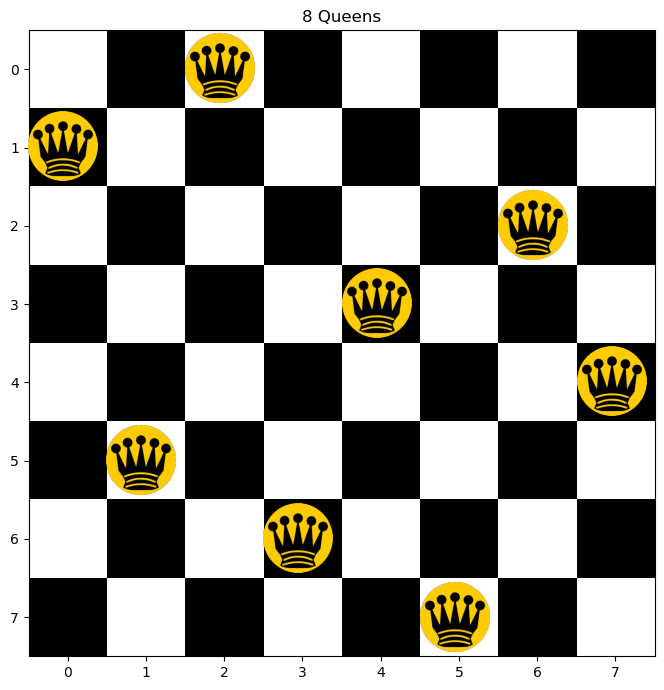

In [299]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
result = []
for i in range(len(solution)):
    result.append(int(solution[i]))
plot_NQueens(result)

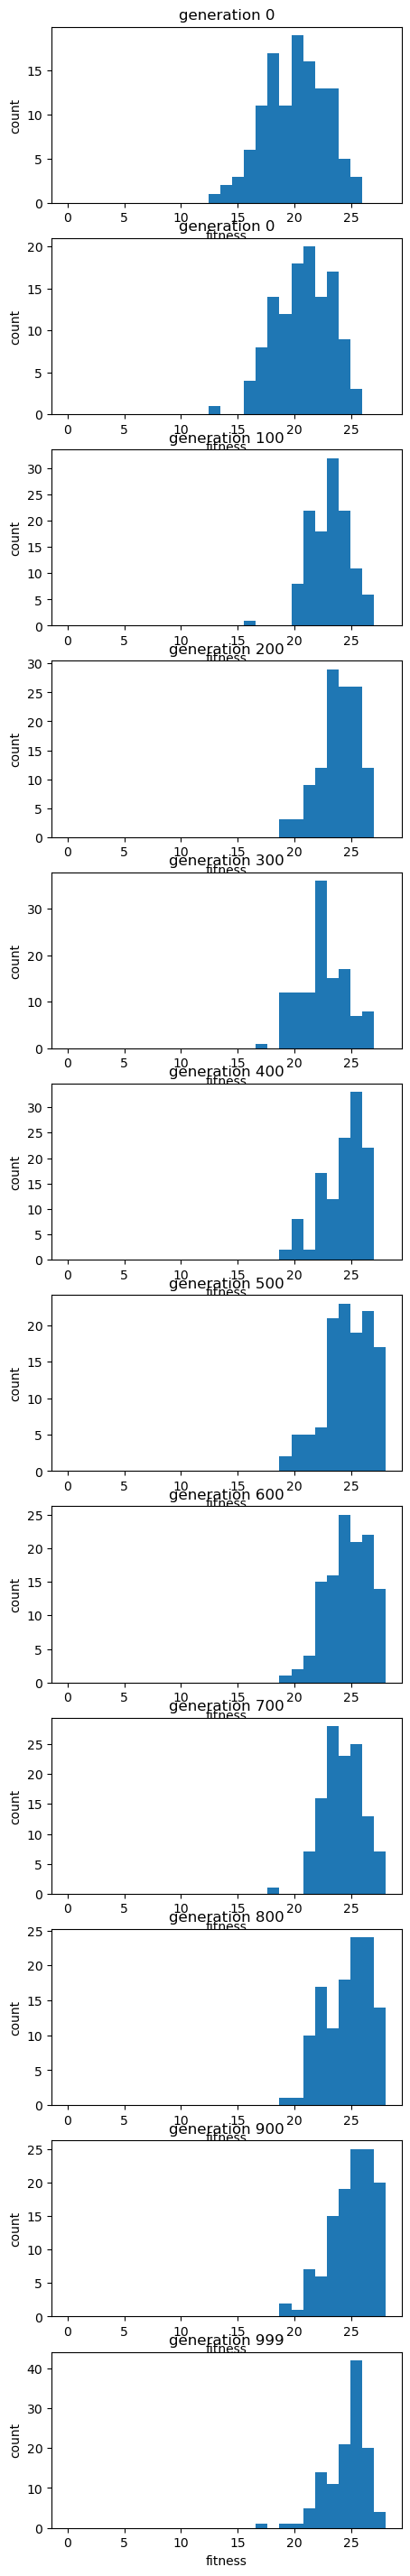

In [300]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)